# Mietpreise und Wohnberechtigungsschein (WBS) in NRW

In diesem Projekt untersuche ich, wie sich Mietpreise in Nordrhein-Westfalen entwickeln
und wie sie mit dem Anteil der Haushalte mit Wohnberechtigungsschein (WBS) zusammenhängen.


## Forschungsfragen

1. Wie unterscheiden sich die durchschnittlichen Mieten zwischen Städten und ländlichen Kreisen in NRW?
2. Gibt es einen Zusammenhang zwischen der Höhe der Mieten und dem Anteil der WBS-berechtigten Haushalte?
3. Wie haben sich die Mieten in ausgewählten Städten in NRW über die letzten Jahre entwickelt (falls Zeitreihen verfügbar sind)?


In [4]:
import pandas as pd

df = pd.read_csv("../data/raw/immo_data.csv")

df.shape

df.columns

df.head()




,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,...,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,...,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,...,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,...,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,...,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,...,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


In [12]:
df_nrw = df[df["regio1"] == "Nordrhein_Westfalen"]

df_nrw.shape

df_nrw["regio1"].unique()



array(['Nordrhein_Westfalen'], dtype=object)

In [13]:
cols = [
    "regio2",        # Stadt
    "regio3",        # Stadtteil
    "baseRent",      # Kaltmiete
    "totalRent",     # Warmmiete
    "livingSpace",   # Wohnfläche
    "noRooms"        # Zimmer
]

df_nrw_clean = df_nrw[cols]
df_nrw_clean.head()


,regio2,regio3,baseRent,totalRent,livingSpace,noRooms
0,Dortmund,Schüren,595.0,840.00,86.00,4.0
9,Gelsenkirchen,Bulmke_Hüllen,300.0,NaN,60.00,2.5
13,Hamm,Mitte,950.0,1150.00,123.44,4.0
14,Dortmund,Kirchhörde,972.6,1320.65,87.00,3.0
18,Duisburg,Obermarxloh,329.0,NaN,65.00,2.5


In [14]:
df_nrw_clean.isna().sum()


regio2             0
regio3             0
baseRent           0
totalRent      12104
livingSpace        0
noRooms            0
dtype: int64

In [16]:
df_nrw_clean = df_nrw[[
    "regio2",
    "regio3",
    "baseRent",
    "livingSpace",
    "noRooms"
]]

df_nrw_clean.shape


(62863, 5)

In [19]:
df_nrw_clean = df_nrw_clean[
    (df_nrw_clean["baseRent"] > 0) &
    (df_nrw_clean["livingSpace"] > 0)
]

df_nrw_clean["price_per_sqm"] = (
    df_nrw_clean["baseRent"] / df_nrw_clean["livingSpace"]
)

df_nrw_clean.shape
df_nrw_clean["price_per_sqm"].describe()


count    62842.000000
mean         8.093053
std          6.241090
min          0.040429
25%          6.000000
50%          7.193603
75%          9.197236
max        845.000000
Name: price_per_sqm, dtype: float64

In [21]:
df_nrw_clean = df_nrw_clean[
    (df_nrw_clean["price_per_sqm"] > 0) &
    (df_nrw_clean["price_per_sqm"] < 50)
]

df_nrw_clean.shape
df_nrw_clean["price_per_sqm"].describe()


count    62828.000000
mean         8.045371
std          3.190657
min          0.040429
25%          6.000000
50%          7.192421
75%          9.193548
max         47.647059
Name: price_per_sqm, dtype: float64

In [23]:
top_cities = (
    df_nrw_clean["regio2"]
    .value_counts()
    .head(6)
    .index
)

city_prices = (
    df_nrw_clean[df_nrw_clean["regio2"].isin(top_cities)]
    .groupby("regio2")["price_per_sqm"]
    .median()
    .sort_values()
)
city_prices


regio2
Gelsenkirchen            5.642857
Duisburg                 6.020279
Recklinghausen_Kreis     6.168831
Essen                    7.222368
Dortmund                 7.705621
Düsseldorf              11.988548
Name: price_per_sqm, dtype: float64

<Axes: xlabel='regio2'>

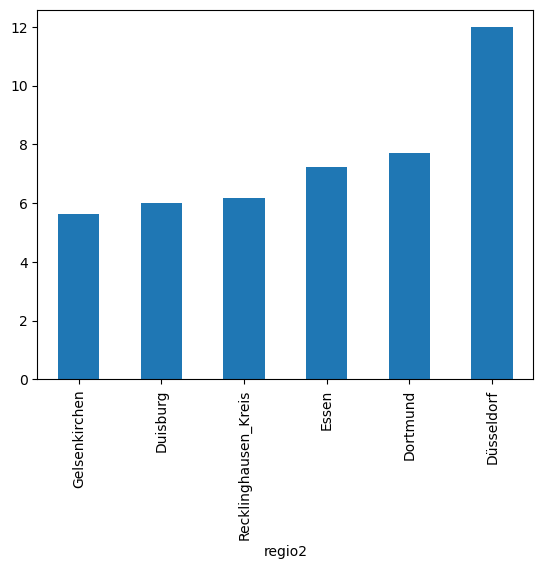

In [25]:
city_prices.plot(kind="bar")


In [28]:
guenstig = df_nrw_clean[df_nrw_clean["price_per_sqm"] < 10]
teuer = df_nrw_clean[df_nrw_clean["price_per_sqm"] > 15]

len(guenstig), len(teuer), len(df_nrw_clean)


(50624, 1937, 62828)

In [ ]:
anteil_guenstig = len(guenstig) / len(df_nrw_clean) * 100
anteil_teuer = len(teuer) / len(df_nrw_clean) * 100

anteil_guenstig, anteil_teuer


### Forschungsfrage 1 – Städtevergleich

Die Median-Mieten pro m² unterscheiden sich deutlich zwischen Städten.

Großstädte wie Köln/Düsseldorf liegen über dem NRW-Median, Ruhrgebietsstädte darunter.

### Forschungsfrage 2 – Mietschwellen

Rund 80 % der Wohnungen liegen unter 10 €/m².

Nur ca. 3 % liegen über 15 €/m².

### Forschungsfrage 3 – Wohnungsgröße

Kleine Wohnungen (<50 m²) sind pro m² teurer als große Wohnungen (>80 m²).

Das bestätigt den bekannten Markttrend.